In [27]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
rcParams['font.family']  = 'Times New Roman'
from sklearn.metrics import roc_curve, auc, classification_report,confusion_matrix,roc_auc_score


warnings.filterwarnings('ignore')


### LS-PLM 数学模型如下
将大规模点击率预测视为数据集 $\{x_t, y_t\}_{t=1}^n$ 的二元分类问题，其中 $y_t \in \{0,1\}$ 和 $x_t \in \mathbb{R}^d$ 是高维且稀疏的。
$$
p(y=1|x) = \sum_{i=1}^m \frac{\exp(u_i^T x)}{\sum_{j=1}^m \exp(u_j^T x)} \cdot \frac{1}{1+\exp(-w_i^T x)} \tag{2}
$$

Equivalent to mixture model:  
$$
p(y=1|x) = \sum_{i=1}^m \underbrace{p(z=i|x)}_{\text{Partition}} \underbrace{p(y|z=i,x)}_{\text{Prediction}} \tag{3}
$$

### Objective Function
$$
\arg\min_\Theta f(\Theta) = \text{loss}(\Theta) + \lambda\|\Theta\|_{2,1} + \beta\|\Theta\|_1 \tag{4}
$$

**Loss Function**:  
$$
\text{loss}(\Theta) = -\sum_{t=1}^n \left[ y_t \log p(y_t=1|x_t,\Theta) + (1-y_t)\log p(y_t=0|x_t,\Theta) \right] \tag{5}
$$

**Parameters**:  
$\Theta = \{u_1,\cdots,u_m, w_1,\cdots,w_m\} \in \mathbb{R}^{d\times 2m}$
- $\{u_j\}$：$\sigma(\cdot)$ 的分区参数
- $\{w_j\}$：$\eta(\cdot)$的预测参数

**Regularizations**:  
1. $L_{2,1}$范数（特征选择）： 
$$
\|\Theta\|_{2,1} = \sum_{i=1}^d \sqrt{\sum_{j=1}^{2m} \theta_{ij}^2}
$$

2. $L_1$ 范数（稀疏性）：
$$
\|\Theta\|_1 = \sum_{i,j} |\theta_{ij}|
$$


In [28]:
class LS_PLM(nn.Module):
    """
    基于LS-PLM的分类模型
    """
    def __init__(self, num_features, num_classes):
        super(LS_PLM, self).__init__()
        # 聚类模型，采用softmax输出类别概率
        self.num_classes = num_classes
        self.cluster_fc = nn.Sequential(
            nn.Linear(num_features, num_classes).float(),
            nn.Softmax(dim=1)
        )
        
        self.lr_fc = nn.Sequential(
            nn.Linear(num_features, self.num_classes, bias= True).float(),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        前向传播函数
        :param x: 输入数据
        :return: 模型输出
        """
        softmax_output = self.cluster_fc(x)
        lr_output = self.lr_fc(x)
        output = torch.sum(softmax_output * lr_output, dim=1, keepdim= True) #与输入维度保持一致
        return output
    
    def get_regularization(self, l1=0., l21=0.):
        """
        计算L1和L2,1正则项
        :param l1: L1正则系数
        :param l21: L2,1正则系数
        :return: 正则损失项
        """
        reg_loss = 0
        
        for name, param in self.named_parameters():
            if 'weight' in name:
                # L2,1正则项 (按行计算L2范数后求和)
                if l21 > 0:
                    row_norms = torch.norm(param, p=2, dim=1)  # 计算每行的L2范数
                    reg_loss += l21 * torch.sum(row_norms)     # 对行范数求和
                    
                # L1正则项
                if l1 > 0:
                    reg_loss += l1 * torch.sum(torch.abs(param))
                    
        return reg_loss

            

In [29]:
# 数据生成和预处理
X, y = make_classification(
    n_samples=1000,
    n_features=15,
    n_informative=10,
    n_classes=2,
    n_redundant=5,
    random_state=42
)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [30]:
# 参数设置
epoch = 100
lr = 0.005
num_classes = 12
batch_size = 32
l1_lambda = 1e-4
l2_1lambda = 1e-5

# 模型构建
model = LS_PLM(X.shape[1], num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=lr)  
criterion = nn.BCELoss(reduction='mean')

In [31]:
# 模型训练
loss_history = []
validation_loss_history = []
Auc_history = []
validation_Auc_history = []

pbar = tqdm(range(epoch), desc='Training')

for i in pbar:
    model.train()
    # 前向传播
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    
    #添加正则化
    reg_loss = model.get_regularization(l1 = l1_lambda, l21 = l2_1lambda)
    total_loss = loss + reg_loss

    # 反向传播
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    loss_history.append(total_loss.item())
    Auc_history.append(roc_auc_score(y_train.detach().numpy(), (y_pred).detach().numpy()))

    model.eval()
    with torch.no_grad():
        y_pred = model(X_validation)
        validation_loss = criterion(y_pred.squeeze(), y_validation)
        validaiton_reg_loss = model.get_regularization(l1_lambda,l2_1lambda)
        total_validation_loss = validation_loss + validaiton_reg_loss

        validation_loss_history.append(total_validation_loss.item())
        validation_Auc_history.append(roc_auc_score(y_validation.detach().numpy(), (y_pred).detach().numpy()))

    pbar.set_postfix({'validation_Loss': f'{total_validation_loss.item():.4f}',
                      'train_loss':f'{total_loss.item():.4f}'})

Training: 100%|██████████| 100/100 [00:00<00:00, 320.36it/s, validation_Loss=0.2201, train_loss=0.1309]


### 模型评估

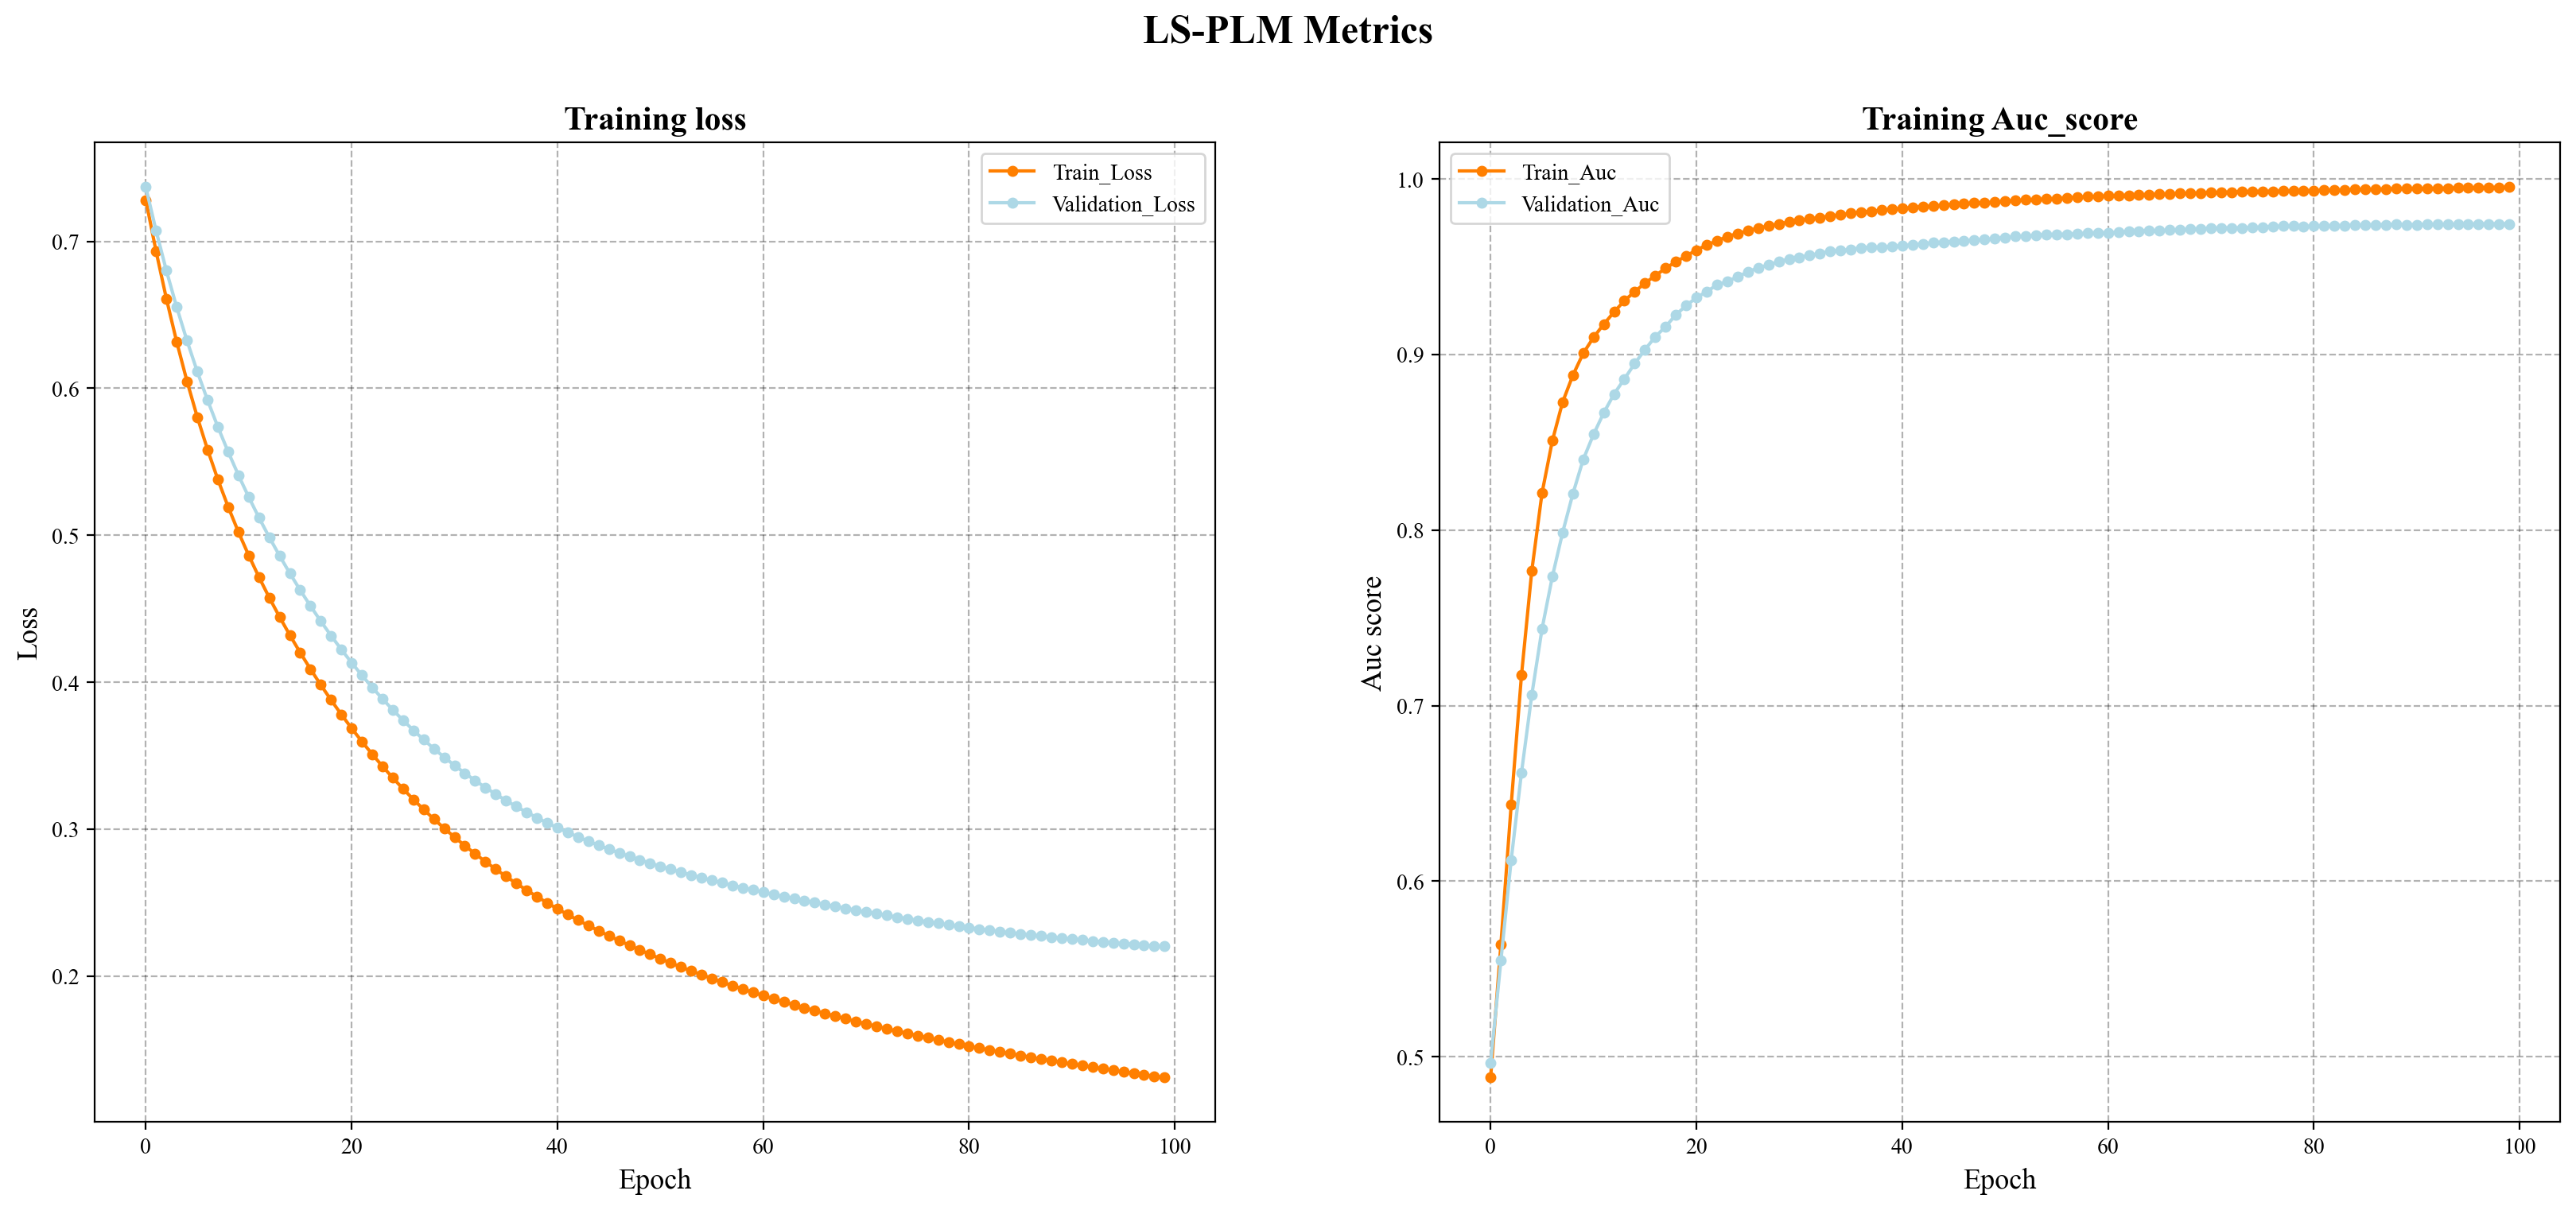

In [32]:
#模型评估
fig,ax = plt.subplots(1,2, figsize = (20,8),dpi = 200)
ax = ax.flatten()

ax[0].set_title('Training loss',weight = 'bold',fontsize = 15)
ax[0].set_xlabel('Epoch',fontsize = 13)
ax[0].set_ylabel('Loss',fontsize = 13)
ax[0].grid(linestyle = '--',alpha = 0.3, color = 'black')
ax[0].plot(loss_history, color = '#FF7F00',label = 'Train_Loss',zorder = 2,marker = 'o'\
          ,markersize = 4)
ax[0].plot(validation_loss_history, color = 'lightblue',label = 'Validation_Loss',zorder = 2,marker = 'o'\
           ,markersize = 4)
ax[0].legend()

ax[1].set_title('Training Auc_score',weight = 'bold',fontsize = 15)
ax[1].set_xlabel('Epoch',fontsize = 13)
ax[1].set_ylabel('Auc score',fontsize = 13)
ax[1].grid(linestyle = '--',alpha = 0.3, color = 'black',zorder = 0)
ax[1].plot(Auc_history, color = '#FF7F00',label = 'Train_Auc',zorder = 2,marker = 'o',markersize = 4)
ax[1].plot(validation_Auc_history, color = 'lightblue',label = 'Validation_Auc',zorder = 2,marker = 'o',markersize = 4)
ax[1].legend()

fig.suptitle('LS-PLM Metrics', fontsize = 18, fontweight='bold')

plt.show()

In [33]:
#预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze() 
    loss = criterion(y_pred, y_test)
    Auc = roc_auc_score(y_test.detach().numpy(), y_pred.detach().numpy())
    print(f"Test Loss: {loss.item():.4f}, Test AUC: {Auc:.4f}")

Test Loss: 0.2033, Test AUC: 0.9811


In [34]:
res = pd.DataFrame(y_pred,columns = ['y_pred'])
res['y_true'] = y_test
res

,y_pred,y_true
0,0.957727,1.0
1,0.341590,1.0
2,0.973541,1.0
3,0.265425,0.0
4,0.990581,1.0
...,...,...
195,0.048703,0.0
196,0.075970,0.0
197,0.890856,1.0
198,0.325010,0.0


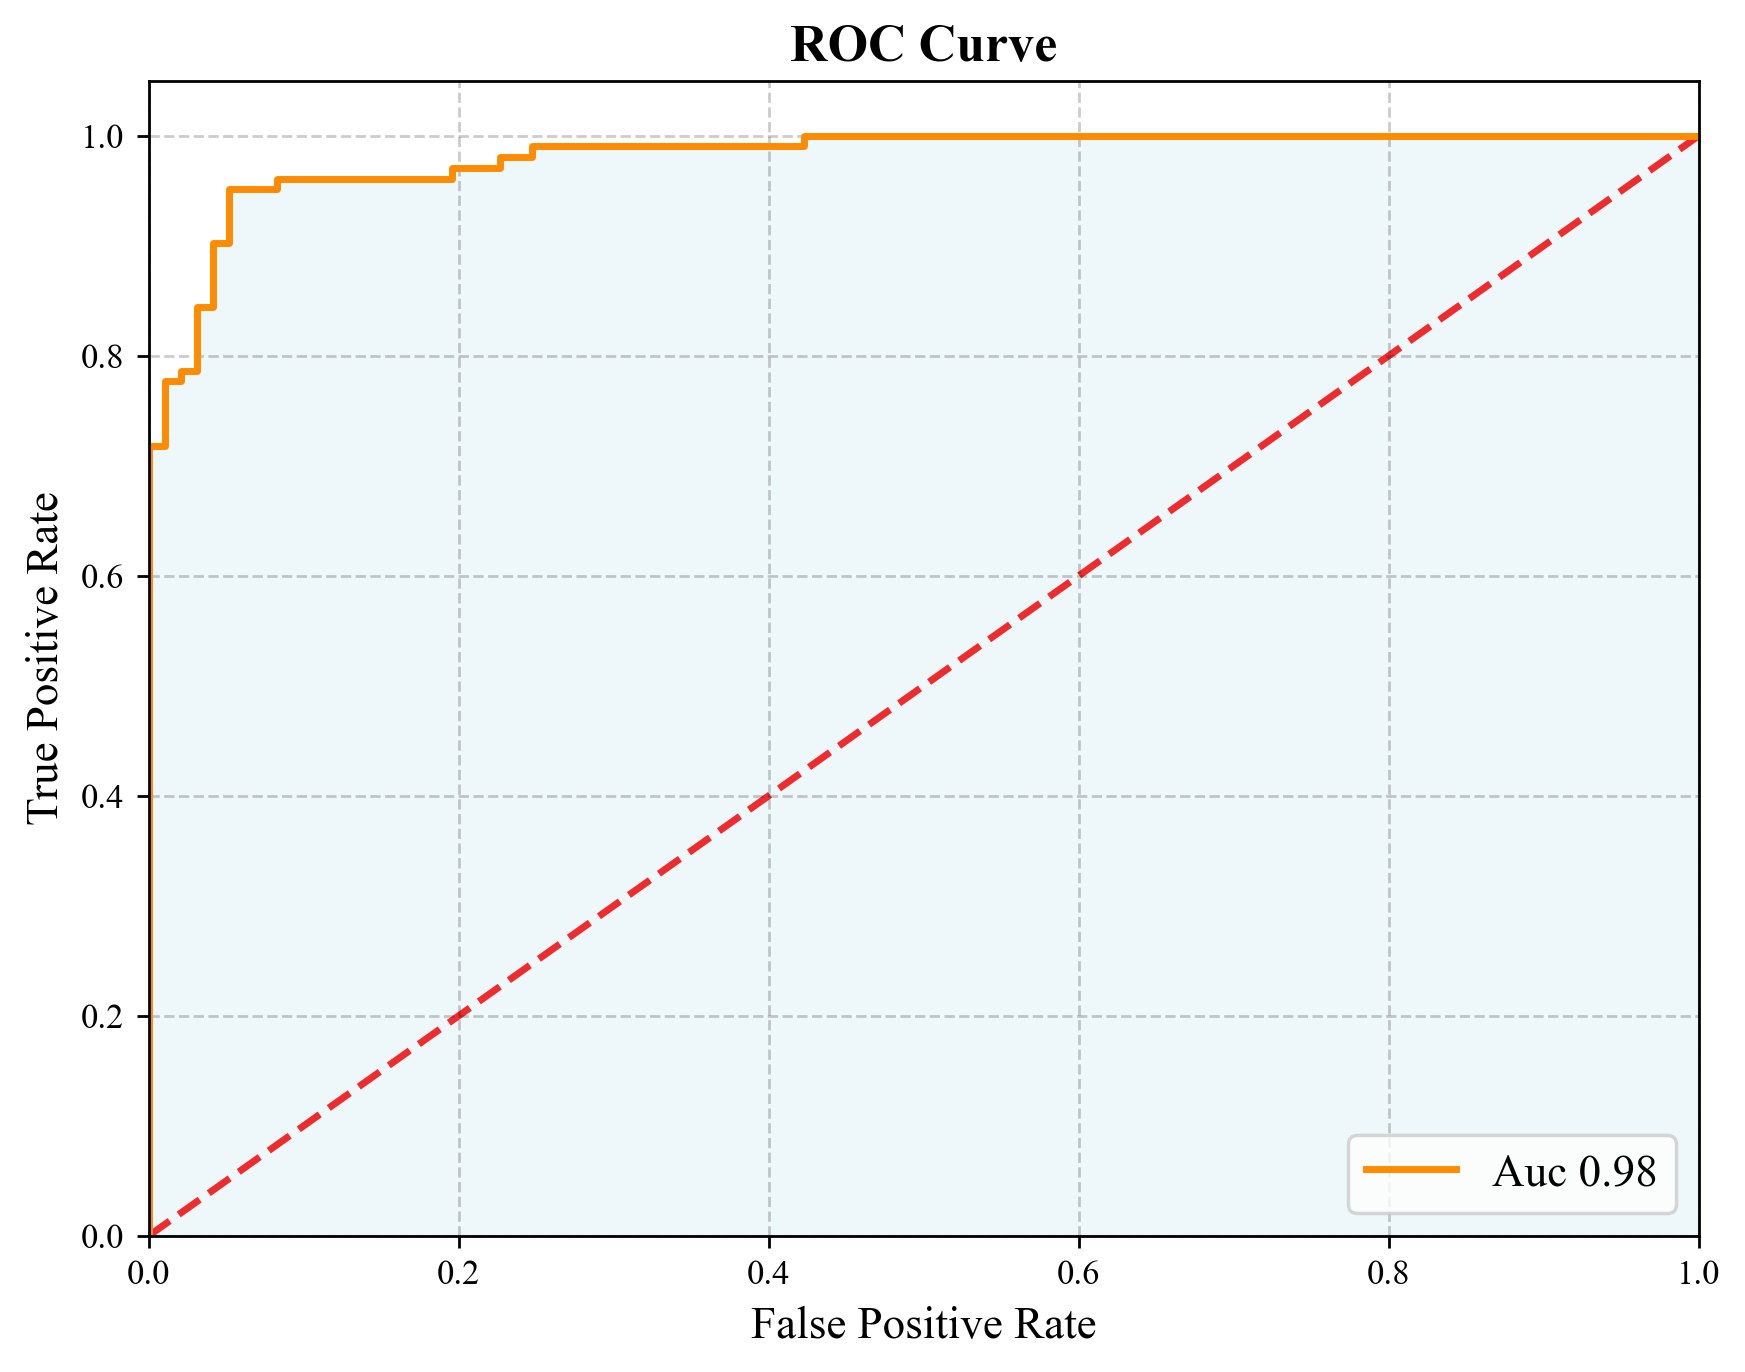

In [35]:
fpr,tpr,threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize = (8,6), dpi = 250)
plt. title('ROC Curve',fontsize = 15, fontweight = 'bold')
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'Auc %.2f' % roc_auc,zorder = 2)
plt.grid(alpha = 0.2,color = 'black', linestyle = '--',zorder = 1)
plt.plot([0,1],[0,1],color = 'red',lw = 2, linestyle = '--',zorder = 1)
plt.legend(loc = 4, fontsize = 13)
plt.fill_between(fpr, tpr, color = 'lightblue', alpha = 0.2)
plt.xlabel('False Positive Rate',fontsize = 13)
plt.ylabel('True Positive Rate',fontsize = 13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()